### Goals  
    1. Load the clinical variables
    2. Process the data as a pandas dataframe
    3. Research SurvhShap, speficially what kind of data it expects.
    4. Create m parameter-cuts of the data as equidistant
    5. Implement an event-sorting algorithm based on the cuts and events.
    6. Finish processing the data so its ready for training
    7. Setup a network alongside the binary-cross-loss (sigmoid on the network output).
    8. Implement a function to create survival function for the chosen slices (0, m)
    9. Plot survival for five individuals
    10. plot accuracy
    11. attempt C-index or Brier score on the network outputs.

In [3]:
import pandas as pd
import openpyxl

In [247]:
#1. Load the clinical data
data = pd.read_excel("Colorectal-Liver-Metastases-Clinical-data-April-2023.xlsx")

/home/anders/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [248]:
#2. Process the data as pandas dataframe
#Dropping the DFS as I'm going to be modeling ordinary survival, without competing interests
surv_data = data[["vital_status", "overall_survival_months"]].copy()
data.drop(columns=["vital_status", "overall_survival_months", "De-identify Scout Name", "months_to_DFS_progression", "vital_status_DFS", "months_to_liver_DFS_progression", "vital_status_liver_DFS", "relevant_notes", "progression_or_recurrence", "progression_or_recurrence_liveronly"], inplace=True)

"""
train_set = data
val_set = train_set.sample(frac=0.2)
train_set.drop(val_set.index, inplace=True)
"""


'\ntrain_set = data\nval_set = train_set.sample(frac=0.2)\ntrain_set.drop(val_set.index, inplace=True)\n'

In [244]:
from sksurv.util import Surv

In [7]:
#Do not run this cell more than once!
#Creating Train and validation sets (using validation as test and validation. )
X_train = data
X_val = X_train.sample(frac=0.2)
X_train.drop(X_val.index, inplace=True)
surv_data_train = surv_data.drop(X_val.index)
surv_data_val = surv_data.drop(X_train.index)
Y_train = Surv.from_dataframe("vital_status", "overall_survival_months", surv_data_train)
Y_val   = Surv.from_dataframe("vital_status", "overall_survival_months", surv_data_val)
print(surv_data.shape)
print(Y_train.shape, Y_val.shape)
print(X_train.shape, X_val.shape)


(197, 2)
(158,) (39,)
(158, 25) (39, 25)


#### 3. Research what types of the data the SurvShap package expects as input

In the original tutorial notebook the data for training and validation go through the same process as the cell above, where the X_train containing the covariates are pandas dataframes and the Y_train have gone through the Surv() package. 

SurvShap also expects some function that returns the Survival equation for all the time-steps based on the network output, and this has to come on the form: 

## So models like the LogisticHazard use sigmoid on the output to essentially output hazard functions for each of the [0,m] times, and then uses binary cross entropy loss to train the network, but what does it train against? No dataset contains h or S values for comparison, so how do you steer this thing?  

The answer is that it assumes the ideal network output is 1 or 0 for the appropriate event_duration.  

so the network could output: 0,0,0,0,1,0,0,1  
which could be compared to:  0,0,1,0,0,0,0,1

using the BCE with logits loss.

In fact I could probably import the loss and the surv and hazard functions from the class to do this.  

## Hold off on the f.y and f.x type inputs until after the network is done. 

In [11]:
X_train.shape

(158, 25)

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [12]:
# 4. Create m-parameter cuts that are equidistant
#Hold off on this. 
"""
TODO:
    - Create an algorithm that creates a set of points from min(overall_survival_months) to max(overall_survival_months), that creates an equidistant set of points between min/max.
    - The algorithm (once set-up) should take an individual's event and survival months as input, and output a binary m-point vector with a right-censored (1 at (i-1) if censored or 1 at i if event). This should be a torch implement to let it work better from the perspective of the training.
"""

class LungCancerDataset(Dataset):
    def __init__(self, x_data, y_data, Overall_surv_months, cutlen, device):
        """
            x_data                  : Training [covariates] data        --> ndarray
            y_data                  : Target data [evennt, duration]    --> ndarray
            Overall_surv_months     : min/max survival                  --> Tuple [min, max]
            cutlen                  : number of cuts                    --> int
            device                  : training device                   --> str
        """
        super().__init__()
        self.device = device
        self.cuts = torch.linspace(Overall_surv_months[0], Overall_surv_months[1], cutlen).to(device=self.device)
        self.x_data = torch.asarray(x_data).to(device=self.device)
        self.y_data = torch.asarray(y_data).to(device=self.device)

    def __len__(self):
        return len(self.x_data.shape[0])
    

    def Prep_sample(self):
        """
        Prepare the sample target according to the discrete cuts
        """

    def __getitem__(self, index):
        pass

In [ ]:
#Creating a dataset that can extract and vizualize the different CT-scans. 
#From the fusion papers this is how to process the images (scaling and normalization etc.)

"""
What steps to take in terms of normalization.
    - B-spline interpolation used to make 3D CT image uniform
    - spacial resolution converted to 1x1x1 mm 
    - pixels with CT-values from -1000 to 400 HU were extracted.

    Random rotation, translation and gaussian noise was added to samples. 


    Gal-bladder study:
        - created 224x224x32 size volumes. (keep in mind gal-bladder is a small organ)

    DeepMMSA:
        - used batch normalization on the sub-networks to create similar-scales before fusion.
"""

In [148]:
#From the CT-ipynb

import pandas as pd
import pydicom as pdc

metadata = pd.read_csv("/home/anders/Phd_Interview_project_dataset/metadata.csv")
pd.set_option('display.max_columns', None)


possible_values = ["CT"]
mask = metadata["Modality"].isin(possible_values)
CT_img_num = metadata[mask].index.tolist()
print(len(CT_img_num))

print(metadata.columns.tolist())

def Get_Patient_SEG(df, patient_ID, mod="CT"):
    return df.loc[(df["Subject ID"] == patient_ID) & (df['modality'] == mod)]

pat_ct = metadata.loc[(metadata['Modality'] == "CT")]
#metadata.loc["CRLM-CT-1001"].isin()

Patients = metadata["Subject ID"]

metadata.head()

# Choosing patient CRLM-CT-1001	as my experimentation patient. 
Patient_ID = "CRLM-CT-1001"

metadata.set_index('Subject ID', inplace=True)

Patient_info = metadata.loc[Patients[8]]

print(Patient_info.iloc[1]["File Location"].strip(" "))

display(Patient_info)



197
['Series UID', 'Collection', '3rd Party Analysis', 'Data Description URI', 'Subject ID', 'Study UID', 'Study Description', 'Study Date', 'Series Description', 'Manufacturer', 'Modality', 'SOP Class Name', 'SOP Class UID', 'Number of Images', 'File Size', 'File Location', 'Download Timestamp']
./Colorectal-Liver-Metastases/CRLM-CT-1005/01-31-1994-NA-CT ANGIO LIVER WITH CHPEL-61769/101.000000-NA-58706


,Series UID,Collection,3rd Party Analysis,Data Description URI,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
Subject ID,,,,,,,,,,,,,,,,
CRLM-CT-1005,1.3.6.1.4.1.14519.5.2.1.9203.8273.118955862549...,Colorectal-Liver-Metastases,NO,https://doi.org/10.7937/QXK2QG03,1.3.6.1.4.1.14519.5.2.1.9203.8273.323837928727...,CT ANGIO LIVER WITH CHPEL,01-31-1994,Segmentation,QIICR,SEG,Segmentation Storage,1.2.840.10008.5.1.4.1.1.66.4,1,12.81 MB,./Colorectal-Liver-Metastases/CRLM-CT-1005/01-...,2024-03-08T13:23:05.116
CRLM-CT-1005,1.3.6.1.4.1.14519.5.2.1.9203.8273.337637593354...,Colorectal-Liver-Metastases,NO,https://doi.org/10.7937/QXK2QG03,1.3.6.1.4.1.14519.5.2.1.9203.8273.323837928727...,CT ANGIO LIVER WITH CHPEL,01-31-1994,NaN,GE MEDICAL SYSTEMS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,141,74.30 MB,./Colorectal-Liver-Metastases/CRLM-CT-1005/01-...,2024-03-08T13:23:16.432


                                            Series UID  \
3    1.3.6.1.4.1.14519.5.2.1.9203.8273.533669585389...   
4    1.3.6.1.4.1.14519.5.2.1.9203.8273.998520027522...   
5    1.3.6.1.4.1.14519.5.2.1.9203.8273.455038217313...   
7    1.3.6.1.4.1.14519.5.2.1.9203.8273.254242588659...   
9    1.3.6.1.4.1.14519.5.2.1.9203.8273.286130801613...   
..                                                 ...   
386  1.3.6.1.4.1.14519.5.2.1.9203.8273.143580197834...   
387  1.3.6.1.4.1.14519.5.2.1.9203.8273.138141006484...   
390  1.3.6.1.4.1.14519.5.2.1.9203.8273.183569989717...   
391  1.3.6.1.4.1.14519.5.2.1.9203.8273.277480301357...   
393  1.3.6.1.4.1.14519.5.2.1.9203.8273.186879497093...   

                      Collection 3rd Party Analysis  \
3    Colorectal-Liver-Metastases                 NO   
4    Colorectal-Liver-Metastases                 NO   
5    Colorectal-Liver-Metastases                 NO   
7    Colorectal-Liver-Metastases                 NO   
9    Colorectal-Liver-Metast

In [150]:
# Ignoring the segmentation maps as this will be purely for generating survival covariate embeddings from the 3D_CT cubes 
pat_ct = metadata.loc[(metadata['Modality'] == "CT")]


(197, 16)

In [67]:
splitstr = "-NA"
loc_strs = Patient_info.iloc[1]["File Location"].strip(" ").split(splitstr)

print(loc_strs[0] + splitstr + "/" + loc_strs[1])

['./Colorectal-Liver-Metastases/CRLM-CT-1075/09-11-1993', '-FORFILE CT ABD ANDOR PEL - CD-50284/5.000000-Abdomen 5.0 B40s-61766']
./Colorectal-Liver-Metastases/CRLM-CT-1075/09-11-1993-NA/-FORFILE CT ABD ANDOR PEL - CD-50284/5.000000-Abdomen 5.0 B40s-61766


In [78]:
import os 

print(len(os.listdir(Get_im_slice(metadata, Patients[8]))))

141


In [110]:
# Going to need data on single CT image-slices.
# Looks like I'm going to have to create my own method for getting the images of an entire patient.
import os 
def Get_pat_imgs(df, patientid):
    loc = "/home/anders/Phd_Interview_project_dataset/" + df.loc[patientid].iloc[1]["File Location"][2:] + "/"
    return loc, sorted(os.listdir(loc))




In [90]:
import time

'\nfor img in dir_list:\n    dcm_img = pdc.dcmread(pat_img_dir + img)\n\n    img_array = dcm_img.pixel_array\n    ax.imshow(img_array)\n    display(fig)\n    clear_output(wait=True)\n    #plt.pause(0.0001)\n\n'

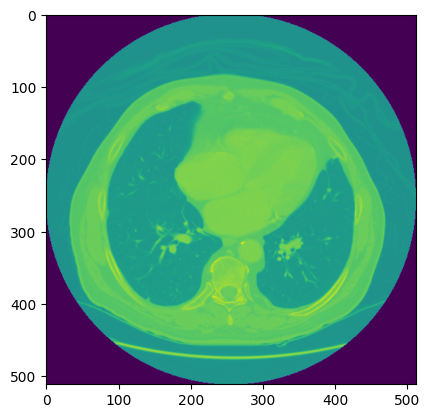

In [125]:
#Viewing a patient image
pat_img_dir, dir_list = Get_pat_imgs(metadata, Patients[8])
#print(pat_img_dir + dir_list[0])
#from IPython.display import display, clear_output
#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1) 

dcm_img = pdc.dcmread(pat_img_dir + dir_list[0])

img_array = dcm_img.pixel_array

plt.imshow(img_array)
"""
for img in dir_list:
    dcm_img = pdc.dcmread(pat_img_dir + img)

    img_array = dcm_img.pixel_array
    ax.imshow(img_array)
    display(fig)
    clear_output(wait=True)
    #plt.pause(0.0001)

"""

torch.Size([512, 512])
(394, 16)


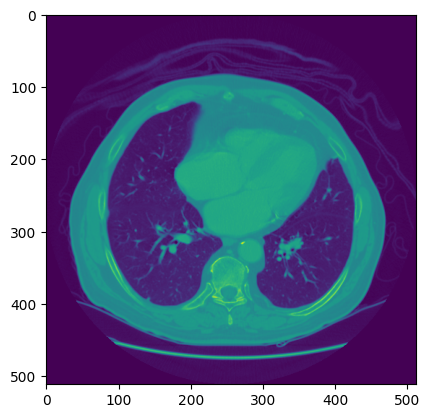

In [147]:
# Investigate image properties to start scaling, normalization and stacking into 3d voxel
# I Don't know anything about Huntsville units and how the features of the luminance would correspond to parts of the body, or which parts would be relevant.

t_im = torch.tensor(img_array).clamp_(min=0).to(float)
print(t_im.size())

image = ( t_im - t_im.mean() ) / t_im.std()

plt.imshow(image.numpy())
print(metadata.isin())

### Creating 3d blocks of CT-images for the neural network (notes)  

2D images are on the form (row, column), denoting 

In [152]:
import torchio as tio
from torch.utils.data import dataloader

In [184]:
# Ignoring the segmentation maps as this will be purely for generating survival covariate embeddings from the 3D_CT cubes 
metadata =pd.read_csv("/home/anders/Phd_Interview_project_dataset/metadata.csv")
pat_ct = metadata.loc[(metadata['Modality'] == "CT")]
patients = pat_ct["Subject ID"].to_numpy()
pat_ct.set_index('Subject ID', inplace=True)

def Get_pat_imgs(df, patientid):
    loc = "/home/anders/Phd_Interview_project_dataset/" + df.loc[patientid]["File Location"][2:] + "/"
    return loc





'/home/anders/Phd_Interview_project_dataset/Colorectal-Liver-Metastases/CRLM-CT-1002/07-12-1992-NA-CT ANGIO ABD WITH CH AND PEL-46457/101.000000-NA-36282/'

In [185]:
subject_1 = tio.Subject(
    t1 = tio.ScalarImage(Get_pat_imgs(pat_ct, patients[2]))
)


In [274]:
# Get covariate data 
data = pd.read_excel("Colorectal-Liver-Metastases-Clinical-data-April-2023.xlsx")
surv_data = data[["vital_status", "overall_survival_months"]].copy()
data.drop(columns=["vital_status", "overall_survival_months", "De-identify Scout Name", "months_to_DFS_progression", "vital_status_DFS", "months_to_liver_DFS_progression", "vital_status_liver_DFS", "relevant_notes", "progression_or_recurrence", "progression_or_recurrence_liveronly"], inplace=True)


def Get_patient_covariate_data(df, patient_ID):
    return torch.tensor(df.loc[df["Patient-ID"] == patient_ID].iloc[:,1:].values)


/home/anders/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [275]:
#Create subjects of all individuals in the dataset:
Transforms = tio.Compose([
    tio.Resample(1),
    tio.ZNormalization(),
    tio.Resize((128,128,240))
])

Subject_list = []

for i,subject in enumerate(patients):
    dir = Get_pat_imgs(pat_ct, subject)
    covariates = Get_patient_covariate_data(data, subject)
    subject = tio.Subject(
    image = tio.ScalarImage(dir),
    covariates = (covariates)
    )
    Subject_list.append(subject)

Subjects_dataset = tio.SubjectsDataset(Subject_list, transform=Transforms)

print("len of subject dataset is:", len(Subjects_dataset))

len of subject dataset is: 197


In [276]:
# Test that Subject and Patient ID correspond
orig_data = pd.read_excel("Colorectal-Liver-Metastases-Clinical-data-April-2023.xlsx")
subject = Subjects_dataset[3]
print("subject covariates:", subject.covariates)
display(orig_data.loc[orig_data["Patient-ID"] == patients[3]])

/home/anders/.local/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


subject covariates: tensor([[39.0000,  1.0000,  1.0000, 22.1000,  1.0000,  1.0000,  1.0000,  3.0000,
          1.0000,  4.4000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.1000,  0.9000,  1.0000,
          0.0000]], dtype=torch.float64)


,Patient-ID,De-identify Scout Name,age,sex,major_comorbidity,body_mass_index,node_positive_primary,synchronous_crlm,multiple_metastases,clinrisk_score,clinrisk_stratified,carcinoembryonic_antigen,max_tumor_size,bilobar_disease,extrahep_disease,chemo_before_liver_resection,preoperative_pve,steatosis_yesno,presence_sinusoidal_dilata,NASH_score,NASH_yesno,NASH_greater_4,total_response_percent,necrosis_percent,fibrosis_percent,fibrosis_greater_40_percent,mucin_percent,overall_survival_months,vital_status,progression_or_recurrence,months_to_DFS_progression,vital_status_DFS,progression_or_recurrence_liveronly,months_to_liver_DFS_progression,vital_status_liver_DFS,relevant_notes
3,CRLM-CT-1004,004_recurrence_preop,39,1,1,22.1,1,1,1,3,1,4.4,0.0,0,0,1,0,0,0,0,0,0,1.0,0.1,0.9,1,0.0,92.0,0,0,92.0,0,0,92.0,0,NaN


In [228]:
from tqdm import tqdm

In [229]:
#DON't run this cell! Runtime is long (37s), and pointless now that the output has been calculated once.
subject = Subjects_dataset[0]
subject["image"].data
k=0
for l in tqdm(range(len(Subjects_dataset))):
    subject = Subjects_dataset[l]
    o = subject["image"].data.size(-1)
    if o >= k:
        k = o
print(k)

# Result is 240, so every Volume must contain [H,W,240]

100%|██████████| 197/197 [00:37<00:00,  5.21it/s]

240


### TODO:
    - Setup the dataset so it can work with clinical variables in addition to CT-images
    - Create a fusion network composed of the CNN, the clinical embedding network and the fusion step with the final survival network. 
    - Setup the Logistic-hazard loss and train. 
    - While training setup code for evaluation (Would it work through Pycox?)

In [280]:
# Downloading and checking out the 3DCNN resnet18 network. 
# image space: (B,H,W,D) (1, 128, 128, 240)



ScalarImage(shape: (1, 128, 128, 240); spacing: (3.19, 3.19, 0.85); orientation: LPS+; dtype: torch.FloatTensor; memory: 15.0 MiB)